In [1]:
import os
# Find the latest version of spark 2.0  from http://www-us.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-2.4.6'
spark_version = 'spark-3.0.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install hyperas

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import itertools

# from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping

from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice,uniform
import numpy as np


# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Fetched 252 kB in 2s (127 kB/s)
Reading package lists... Done


In [2]:
batch_size = 32  # The default batch size of keras.
num_classes = 10  # Number of class for the dataset
epochs = 50
data_augmentation = False

In [3]:
# The data, split between train and test sets:
(X_train, y_train), (x_test, y_test) = cifar10.load_data()
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print(X_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
50000 train samples
10000 test samples


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


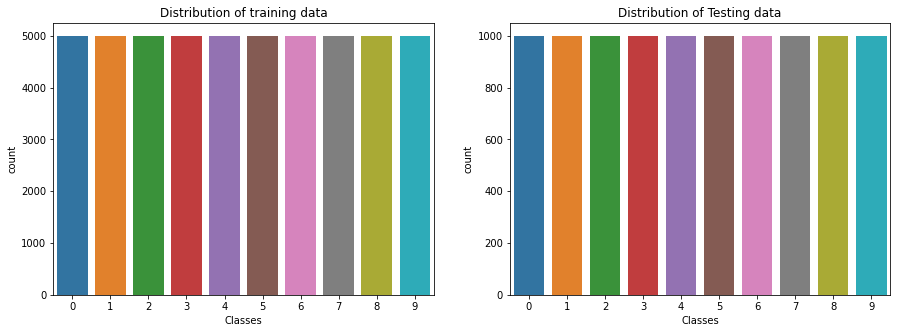

In [4]:
fig, axs = plt.subplots(1,2,figsize=(15,5)) 
# Count plot for training set
sns.countplot(y_train.ravel(), ax=axs[0])
axs[0].set_title('Distribution of training data')
axs[0].set_xlabel('Classes')
# Count plot for testing set
sns.countplot(y_test.ravel(), ax=axs[1])
axs[1].set_title('Distribution of Testing data')
axs[1].set_xlabel('Classes')
plt.show()

In [5]:
# Normalize the data. Before we need to connvert data type to float for computation.
X_train = X_train.astype('float32')
x_test = x_test.astype('float32')
X_train /= 255
x_test /= 255

# Convert class vectors to binary class matrices. This is called one hot encoding.
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
from sklearn.model_selection import train_test_split

def data():
    (X_train, y_train), (x_test, y_test) = cifar10.load_data()
    # X_train = X_train.reshape(50000, 3072)
    # x_test = x_test.reshape(10000, 3072)
    # Normalize the data. Before we need to connvert data type to float for computation.
    X_train = X_train.astype('float32')
    x_test = x_test.astype('float32')
    X_train /= 255
    x_test /= 255
    num_classes = 10

    # Convert class vectors to binary class matrices. This is called one hot encoding.
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, random_state=42, test_size=0.2)
    return X_train2, y_train2, X_val, y_val

In [8]:
X_train2, y_train2, X_val, y_val = data()
print('X_train shape:', X_train2.shape)
print('y_train shape:', y_train2.shape)
print('x_val shape:', X_val.shape)
print('y_val shape:', y_val.shape)
X_train2.shape[1:]

X_train shape: (40000, 32, 32, 3)
y_train shape: (40000, 10)
x_val shape: (10000, 32, 32, 3)
y_val shape: (10000, 10)


(32, 32, 3)

In [1]:
def create_model(X_train2, y_train2, X_val, y_val):

    num_classes = 10

    #define the convnet

    model = Sequential()

    # CONV => RELU => CONV => RELU => POOL => DROPOUT

    model.add(Conv2D({{choice([16, 32, 64])}}, 
                     kernel_size={{choice([(3, 3),(5,5)])}},
                     padding="valid",input_shape=X_train2.shape[1:]))
    
    model.add(Activation('relu'))

    model.add(Conv2D({{choice([16, 32, 64])}}, 
                     kernel_size={{choice([(3, 3),(5,5)])}},
                     padding="valid"))
    
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(MaxPooling2D(pool_size={{choice([(2, 2),(4,4)])}}))

    model.add(Dropout({{uniform(0, 1)}}))

    # CONV => RELU => CONV => RELU => POOL => DROPOUT

    model.add(Conv2D({{choice([16, 32, 64])}}, 
                     kernel_size={{choice([(3, 3),(5,5)])}}, 
                     padding='valid'))
    
    model.add(Activation('relu'))

    model.add(Conv2D({{choice([16, 32, 64])}}, 
                     kernel_size={{choice([(3, 3),(5,5)])}}))
    
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(MaxPooling2D(pool_size={{choice([(2, 2),(4,4)])}}))

    model.add(Dropout({{uniform(0, 1)}}))

    # FLATTERN => DENSE => RELU => DROPOUT

    model.add(Flatten())

    model.add(Dense(512))

    model.add(Activation({{choice(['relu', 'tanh'])}}))

    model.add(Dropout({{uniform(0, 1)}}))

    # a softmax classifier

    model.add(Dense(num_classes))

    model.add(Activation('softmax'))

    # initiate RMSprop optimizer
    opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)



    # Let's train the model using RMSprop
    model.compile(loss='categorical_crossentropy',
                  optimizer={{choice(['rmsprop', 'adam', 'sgd'])}},
                  metrics=['accuracy'])
    
    callback = EarlyStopping(monitor='loss', patience=5)
    
    result = None  # For recording the history of training process.

    result = model.fit(X_train2, y_train2,
                batch_size={{choice([16, 32, 64])}},
                epochs={{choice([20,50,100])}},
                verbose=2,
                validation_split=0.1,
                callbacks = [callback])
    
    # Score trained model.
    scores = model.evaluate(X_val, y_val, verbose=1)

    # make prediction.
    pred = model.predict(x_test)

    validation_acc = np.amax(result.history['val_accuracy']) 
    print('Best validation acc of epoch:', validation_acc)
    return {'loss': -validation_acc, 'status': STATUS_OK, 'model': model}
   

In [10]:
# See: https://stackoverflow.com/questions/49920031/get-the-path-of-the-notebook-on-google-colab
# Install the PyDrive wrapper & import libraries.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Copy/download the file
fid = drive.ListFile({'q':"title='cifar10_cnn_tuning_hyporas_v2.ipynb'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('cifar10_cnn_tuning_hyporas_v2.ipynb')

In [11]:
best_run, best_model = optim.minimize(model=create_model,
                                      data=data,
                                      algo=tpe.suggest,
                                      max_evals=5,
                                      trials=Trials(),
                                      notebook_name='cifar10_cnn_tuning_hyporas_v2')

X_train2, y_train2, X_val, y_val = data()
print("Evalutation of best performing model:")
print(best_model.evaluate(X_val, y_val)) 
print("Best performing model chosen hyper-parameters:")
print(best_run)

>>> Imports:
#coding=utf-8

try:
    import os
except:
    pass

try:
    import seaborn as sns
except:
    pass

try:
    import matplotlib
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    from sklearn.metrics import confusion_matrix, classification_report
except:
    pass

try:
    import itertools
except:
    pass

try:
    import keras
except:
    pass

try:
    from keras.datasets import cifar10
except:
    pass

try:
    from keras.preprocessing.image import ImageDataGenerator
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras.layers import Dense, Dropout, Activation, Flatten
except:
    pass

try:
    from keras.layers import Conv2D, MaxPooling2D
except:
    pass

try:
    from keras.callbacks import EarlyStopping
except:
    pass

try:
    from hyperopt import Trials, STATUS_OK, tpe
except:
    pass

try:
    from hyperas import optim
except:
    pass

try:
    from hyperas.distributions impo

NameError: ignored

In [ ]:
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history.history.keys())

plotmodelhistory(history)


In [ ]:
# # Score trained model.
# scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# # make prediction.
# pred = model.predict(x_test)

In [ ]:
def heatmap(data, row_labels, col_labels, ax=None, cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.
    """
    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)
    
    ax.set_xlabel('Predicted Label') 
    ax.set_ylabel('True Label')
    
    return im, cbar

def annotate_heatmap(im, data=None, fmt="d", threshold=None):
    """
    A function to annotate a heatmap.
    """
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text = im.axes.text(j, i, format(data[i, j], fmt), horizontalalignment="center",
                                 color="white" if data[i, j] > thresh else "black")
            texts.append(text)

    return texts

In [ ]:
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(pred, axis=1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis=1)
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = pred[errors]
Y_true_errors = Y_true[errors]
X_test_errors = x_test[errors]

cm = confusion_matrix(Y_true, Y_pred_classes) 
thresh = cm.max() / 2.

fig, ax = plt.subplots(figsize=(12,12))
im, cbar = heatmap(cm, labels, labels, ax=ax,
                   cmap=plt.cm.Blues, cbarlabel="count of predictions")
texts = annotate_heatmap(im, data=cm, threshold=thresh)

fig.tight_layout()
plt.show()

In [ ]:
print(classification_report(Y_true, Y_pred_classes))

In [ ]:
R = 5
C = 5
fig, axes = plt.subplots(R, C, figsize=(12,12))
axes = axes.ravel()

for i in np.arange(0, R*C):
    axes[i].imshow(x_test[i])
    axes[i].set_title("True: %s \nPredict: %s" % (labels[Y_true[i]], labels[Y_pred_classes[i]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

In [ ]:
def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    """ This function shows 10 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 5
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True, figsize=(12,6))
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((32,32,3)))
            ax[row,col].set_title("Predicted:{}\nTrue:{}".
                                  format(labels[pred_errors[error]],labels[obs_errors[error]]))
            n += 1
            ax[row,col].axis('off')
            plt.subplots_adjust(wspace=1)

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 10 errors 
most_important_errors = sorted_dela_errors[-10:]

# Show the top 10 errors
display_errors(most_important_errors, X_test_errors, Y_pred_classes_errors, Y_true_errors)

In [ ]:
def show_test(number):
    fig = plt.figure(figsize = (3,3))
    test_image = np.expand_dims(x_test[number], axis=0)
    test_result = model.predict_classes(test_image)
    plt.imshow(x_test[number])
    dict_key = test_result[0]
    plt.title("Predicted: {} \nTrue Label: {}".format(labels[dict_key],
                                                      labels[Y_true[number]]))

In [ ]:
show_test(20)

In [ ]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])